# PCA for Algorithmic Trading: Eigen Portfolios

## Imports & Settings

In [78]:
import warnings
warnings.filterwarnings('ignore')

In [79]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [80]:
sns.set_style('white')
np.random.seed(42)

## Eigenportfolios

Another application of PCA involves the covariance matrix of the normalized returns. The principal components of the correlation matrix capture most of the covariation among assets in descending order and are mutually uncorrelated. Moreover, we can use standardized the principal components as portfolio weights.

Let’s use the 30 largest stocks with data for the 2010-2018 period to facilitate the exposition:

### Data Preparation

In [81]:
#idx = pd.IndexSlice
#with pd.HDFStore('../../data/assets.h5') as store:
#    stocks = store['us_equities/stocks'].marketcap.nlargest(30)
#    returns = (store['quandl/wiki/prices']
#               .loc[idx['2010': '2018', stocks.index], 'adj_close']
#               .unstack('ticker')
#               .pct_change())

In [82]:
import pandas_datareader.data as web
from datetime import datetime
from dateutil.relativedelta import relativedelta

def download_data(lookback):
    # Downloading data
    #stocks = ['SPY', 'TLT', 'GLD', '^VIX', 'SSG', 'FXI', 'REK', 'RWM', 'SEF', 'EFZ', 'SH', 'SJB', '^OMX', 'IEF', 'DBC', 'VNQ']
    #stocks = ['SPY', 'TLT', 'GLD', '^VIX', 'DBC', '^OMX', 'IEF', 'VNQ']
    stocks = ['TSLA', 'TLT', 'GC=F', '^VIX']
    #stocks = ['SALT-B.ST', 'VSSAB-B.ST', 'LEO.ST', 'SAAB-B.ST', 
    #         'VICO.ST', 'IPCO.ST', 'BONEX.ST', 'CAMX.ST', 'ARP.ST', 'SPY', 'TLT', 'GLD', 'DBC', '^OMX', 'IEF', 'VNQ']
    #stocks = ['CRNC', 'ERIC', 'GHUS-B.ST', 'FRACTL.ST', 'QLIRO.ST',
    #          'SLVM', 'CCSI', 'VTSC.DE', 'ANNE-B.ST', 'MAXN', 'VMEO', 'GLD', '^VIX', 'DBC'] # Spinoffs
    #stocks = ['SPY', 'TLT', 'GLD', '^VIX', 'CSD', 'DBC', 'VNQ', 'IEF'] # CSD = Invesco S&P Spin-Off ETF
    #stocks = ['SPY', 'TLT', 'GLD', '^VIX', 'CSD', 'DBC', 'VNQ', 'CL=F'] # CSD = Invesco S&P Spin-Off ETF
    #stocks = ['SPY', 'TLT', 'GLD', 'IEF', 'DBC', '^VIX','VNQ']
    #stocks = ['VTI', 'TLT', 'GLD', 'DBC', 'IEF'] # All weather portfolio
    #stocks = ['BWX', 'DBC', 'EMB', 'GLD', 'IYR', 'RWX', 'TLT', 'VGK', 'VPL', 'VTI', 'VWO']
    #stocks = ['^OMX', 'TLT', 'IEF', 'DBC']
    #stocks = ['ERDN.SG', 'FRNRX', 'GLD', 'TLT']
    start_date = datetime.now() - relativedelta(years = lookback)
    end_date = datetime.today().strftime('%Y-%m-%d')
    Y = web.DataReader(stocks, 'yahoo', start_date, end_date)['Adj Close'].pct_change().dropna()
    return Y

In [83]:
lookback = 20
returns = download_data(lookback)

We again winsorize and also normalize the returns:

In [84]:
normed_returns = scale(returns
                       .clip(lower=returns.quantile(q=.025), 
                             upper=returns.quantile(q=.975), 
                             axis=1)
                      .apply(lambda x: x.sub(x.mean()).div(x.std())))

In [85]:
returns = returns.dropna(thresh=int(returns.shape[0] * .95), axis=1)
returns = returns.dropna(thresh=int(returns.shape[1] * .95))
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3068 entries, 2010-06-30 to 2022-09-02
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TSLA    3068 non-null   float64
 1   TLT     3068 non-null   float64
 2   GC=F    3068 non-null   float64
 3   ^VIX    3068 non-null   float64
dtypes: float64(4)
memory usage: 119.8 KB


In [86]:
cov = returns.cov()

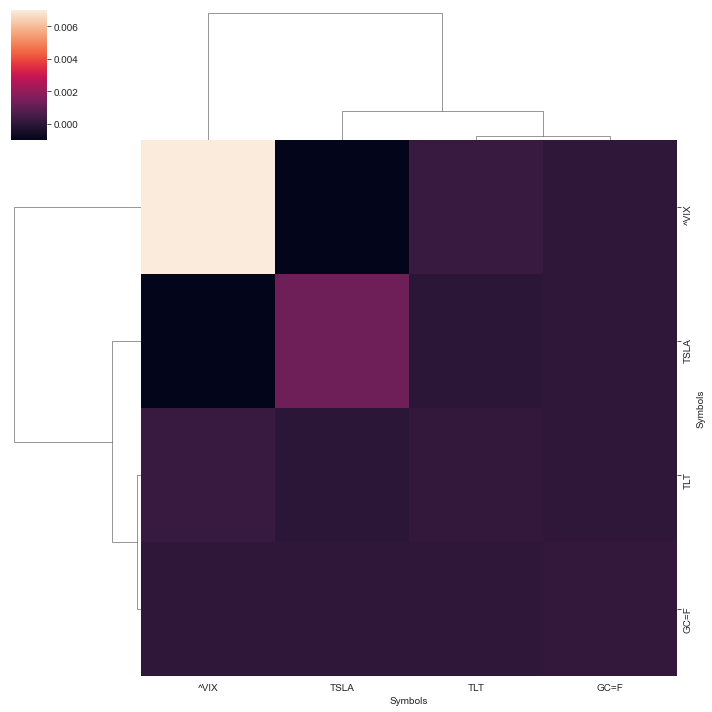

In [87]:
sns.clustermap(cov);

### Run PCA

After dropping assets and trading days as in the previous example, we are left with 23 assets and over 2,000 trading days. We estimate all principal components and find that the two largest explain 57.6% and 12.4% of the covariation, respectively:

In [88]:
pca = PCA()
pca.fit(cov)
pd.Series(pca.explained_variance_ratio_).to_frame('Explained Variance').head().style.format('{:,.2%}'.format)

,Explained Variance
0,98.26%
1,1.72%
2,0.01%
3,0.00%


### Create PF weights from principal components

Next, we select and normalize the four largest components so that they sum to 1 and we can use them as weights for portfolios that we can compare to an equal-weighted portfolio formed from all stocks::

In [89]:
n = len(returns.columns)
top4 = pd.DataFrame(pca.components_[:n], columns=cov.columns)
eigen_portfolios = top4.div(top4.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range(1, n + 1)]

### Eigenportfolio Weights

The weights show distinct emphasis, e.g., portfolio 3 puts large weights on Mastercard and Visa, the two payment processors in the sampel whereas potfolio 2 has more exposure to some technology companies:

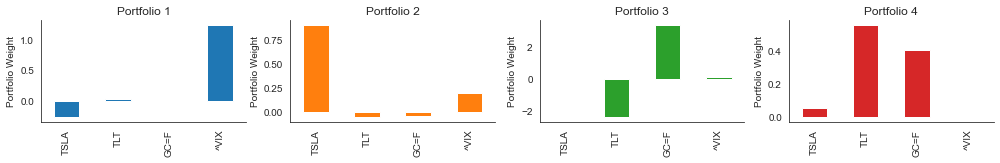

In [90]:
axes = eigen_portfolios.T.plot.bar(subplots=True,
                                   layout=(n, n),
                                   figsize=(14, 8),
                                   legend=False)
for ax in axes.flatten():
    ax.set_ylabel('Portfolio Weight')
    ax.set_xlabel('')
sns.despine()
plt.tight_layout()

### Eigenportfolio Performance

When comparing the performance of each portfolio over the sample period to ‘the market’ consisting of our small sample, we find that portfolio 1 performs very similarly, whereas the other portfolios capture different return patterns.

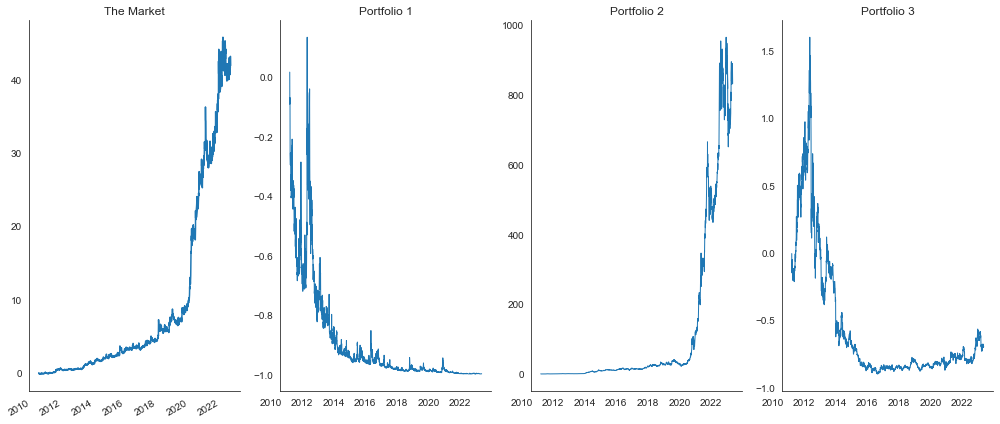

In [91]:
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(14, 6), sharex=True)
axes = axes.flatten()
returns.mean(1).add(1).cumprod().sub(1).plot(title='The Market', ax=axes[0])
for i in range(3):
    rc = returns.mul(eigen_portfolios.iloc[i]).sum(1).add(1).cumprod().sub(1)
    rc.plot(title=f'Portfolio {i+1}', ax=axes[i+1], lw=1, rot=0)

for i in range(n):
    axes[i].set_xlabel('')
sns.despine()
fig.tight_layout()

In [92]:
print(eigen_portfolios)

Symbols          TSLA       TLT      GC=F      ^VIX
Portfolio 1 -0.265874  0.038549 -0.005266  1.232592
Portfolio 2  0.897570 -0.054261 -0.038451  0.195142
Portfolio 3 -0.021748 -2.445574  3.381083  0.086239
Portfolio 4  0.051528  0.552708  0.400225 -0.004461
